In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ydata_profiling
import seaborn as sns
import warnings
import os
import yellowbrick
import scipy.cluster.hierarchy as shc
import matplotlib.patches as patches

from matplotlib.patches import Rectangle
from ydata_profiling import ProfileReport
from pywaffle import Waffle
from math import isnan
from random import sample
from numpy.random import uniform
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.style import set_palette
from yellowbrick.contrib.wrapper import wrap

In [27]:
class clr:
    start = '\033[93m'+'\033[1m'
    color = '\033[93m'
    end = '\033[0m'

In [8]:
# Read and show the data
df = pd.read_csv(r"C:\Users\郑乾皓\Desktop\marketing_campaign.csv",sep ='\t')
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


In [ ]:
df.shape

In [ ]:
# --- Dataset Report ---
#profile = ProfileReport(df, title='Customer Dataset Report', explorative=False)
#profile.to_notebook_iframe()


In [ ]:
#profile.to_file("report.html")


# 数据预处理
1. 针对“Marital_Status”重新分类，分为“Partner”和“Alone”两类，命名为“Living_With”
2. 针对“Education”重新分类，分为“Undergraduate”，“Graduate”和“Postgraduate”三类
3. 通过“Year_Birth”计算消费者年龄，命名为“Age”
4. 通过“Dt_Customer”计算消费者从注册至今的天数（至最后一个消费者注册时间），命名为“customer_for”
5. 通过“MntWines”等字段计算出消费者近两年在葡萄酒、水果、肉类、鱼类、糖果和黄金上的总花费金额，命名为“amount_spend”
6. 通过上述“customer_for”和“amount_spend”两个指标计算用户生命周期价值，"amount_spent" / (("customer_for" + 1) / 365)，命名为“life_time_value”

In [10]:
X

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Living_With,Age,customer_for,amount_spent,life_time_value
0,Graduate,58138.0,0,0,58,635,88,546,172,88,...,3,8,10,4,7,Alone,64,663,1617,888.862952
1,Graduate,46344.0,1,1,38,11,1,6,2,1,...,2,1,1,2,5,Alone,67,113,27,86.447368
2,Graduate,71613.0,0,0,26,426,49,127,111,21,...,1,8,2,10,4,Partner,56,312,776,904.920128
3,Graduate,26646.0,1,0,26,11,4,20,10,3,...,2,2,0,4,6,Partner,37,139,53,138.178571
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,...,5,5,3,6,5,Partner,40,161,422,950.802469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,Graduate,61223.0,0,1,46,709,43,182,42,118,...,2,9,3,4,5,Partner,54,381,1341,1281.321990
2236,Postgraduate,64014.0,2,1,56,406,0,30,0,0,...,7,8,2,5,7,Partner,75,19,444,8103.000000
2237,Graduate,56981.0,0,0,91,908,48,217,32,12,...,1,2,3,13,6,Alone,40,155,1241,2903.621795
2238,Postgraduate,69245.0,0,1,8,428,30,214,80,30,...,2,6,5,10,3,Partner,65,156,843,1959.840764


In [9]:
# Feature Engineering

# Deriving living situation by marital status"Alone"
df["Living_With"] = df["Marital_Status"].replace(
    {
        "Married": "Partner",
        "Together": "Partner",
        "Absurd": "Alone",
        "Widow": "Alone",
        "YOLO": "Alone",
        "Divorced": "Alone",
        "Single": "Alone",
    }
)



# Segmenting education levels in three groups
df["Education"] = df["Education"].replace(
    {
        "Basic": "Undergraduate",
        "2n Cycle": "Undergraduate",
        "Graduation": "Graduate",
        "Master": "Postgraduate",
        "PhD": "Postgraduate",
    }
)



# Create 'Age' feature.
# I am not sure when the data is collected but it could be in 2021. Let's just use 2021 as 'today' to calculate the age.
today = 2021
df['Age'] = today - df['Year_Birth']

# cREATE how long has been customer
def extract_day(date):
    day = str(date).split(" ", 1)[0]
    return pd.to_numeric(day, errors="coerce")
df["Dt_Customer"] = df["Dt_Customer"].apply(pd.to_datetime, dayfirst=True, errors="coerce")
df["customer_for"] = df["Dt_Customer"].max() - df["Dt_Customer"]
df["customer_for"] = df["customer_for"].apply(extract_day)
df["amount_spent"] = df["MntWines MntFruits MntMeatProducts MntFishProducts MntSweetProducts MntGoldProds".split()].sum(axis=1)
df["life_time_value"] = df["amount_spent"] / ((df["customer_for"] + 1) / 365)

# Dropping some of the redundant features
to_drop = [
    "Marital_Status",
    "Dt_Customer",
    "Z_CostContact",
    "Z_Revenue",
    "Year_Birth",
    "ID",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "Complain",
    "Response",
]

X = df.drop(to_drop, axis=1, errors="ignore")

# 特征工程
将'Education', 'Living_With'两个特征进行编码

In [17]:
categorical_features = ['Education', 'Living_With']
le=LabelEncoder()
for i in categorical_features:
    X[i]=X[[i]].apply(le.fit_transform)


我跑出来的特征工程结果：

In [19]:
for feature in categorical_features:
    print(X[feature].value_counts())

Education
0    1127
1     856
2     257
Name: count, dtype: int64
Living_With
1    1444
0     796
Name: count, dtype: int64


# 异常值处理
1. 找到Dataframe中有缺失值的列 -> 'Income'
2. 通过KNNImputer估算缺失值并补充

In [20]:
#Imputation
# --- List Null Columns ---
null_columns = X.columns[X.isnull().any()].tolist()

# --- Perform Imputation ---
imputer = KNNImputer()
X_imp = pd.DataFrame(imputer.fit_transform(X[null_columns]), columns=null_columns)
X = X.fillna(X_imp)

# 标准化处理
对Dataframe中所有特征进行标准化处理，是所有特征符合标准正态分布

In [23]:
#  scaling
# --- Scaling Dataset w/ Standard Scaler ---
X = pd.DataFrame(StandardScaler().fit_transform(X))

In [25]:
X

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-0.894974,0.235327,-0.825218,-0.929894,0.307039,0.983781,1.551577,1.679702,2.462147,1.476500,...,0.349414,1.409304,2.510890,-0.550785,0.693904,-1.346874,0.985345,1.531185,1.679417,-0.095144
1,-0.894974,-0.235826,1.032559,0.906934,-0.383664,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,...,-0.168236,-1.110409,-0.568720,-1.166125,-0.130463,-1.346874,1.235733,-1.190545,-0.961275,-0.175812
2,-0.894974,0.773633,-0.825218,-0.929894,-0.798086,0.362723,0.570804,-0.177032,1.345274,-0.146905,...,-0.685887,1.409304,-0.226541,1.295237,-0.542647,0.742460,0.317643,-0.205773,0.282673,-0.093530
3,-0.894974,-1.022732,1.032559,-0.929894,-0.798086,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,...,-0.168236,-0.750450,-0.910898,-0.550785,0.281720,0.742460,-1.268149,-1.061881,-0.918094,-0.170612
4,0.568341,0.241519,1.032559,-0.929894,1.550305,-0.389085,0.419916,-0.216914,0.155164,-0.001525,...,1.384715,0.329427,0.115638,0.064556,-0.130463,0.742460,-1.017761,-0.953012,-0.305254,-0.088917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,-0.894974,0.358568,-0.825218,0.906934,-0.107383,1.203678,0.419916,0.066692,0.081926,2.203398,...,-0.168236,1.769263,0.115638,-0.550785,-0.130463,0.742460,0.150717,0.135680,1.221032,-0.055690
2236,0.568341,0.470064,2.890335,0.906934,0.237969,0.303291,-0.661449,-0.606873,-0.687068,-0.655733,...,2.420015,1.409304,-0.226541,-0.243114,0.693904,0.742460,1.903435,-1.655713,-0.268717,0.630104
2237,-0.894974,0.189106,-0.825218,-0.929894,1.446700,1.795020,0.545656,0.221789,-0.101168,-0.364974,...,-0.685887,-0.750450,0.115638,2.218248,0.281720,-1.346874,-1.017761,-0.982703,1.054951,0.107402
2238,0.568341,0.679035,-0.825218,0.906934,-1.419719,0.368666,0.092992,0.208495,0.777683,0.071165,...,-0.168236,0.689386,0.799996,1.295237,-0.954831,0.742460,1.068807,-0.977755,0.393948,0.012523


In [31]:
hopkins_value

0.8977442437864566

# 判断是否具备聚类结构
通过kneighbors实现hopkins统计以判断是否具备聚类结构

1. 计算均匀分布的样本点和数据集中的样本点的距离，得到最近的两个数据点，保存为ujd。
   eg.[[11.05623447 11.3705341 ]]
2. 计算随机抽样的样本点和数据集中最近邻样本点的距离，得到最近的两个数据点，保存为wjd。
   eg.[[8.42936970e-08 3.35145321e+00]]
3. 通过sum(ujd) / (sum(ujd) + sum(wjd))得到hopkins_value
   eg.0.8991

结论：hopkins_value > 0.7，具有较强的聚类倾向性

In [33]:
# --- Hopkins Test (codes by Matevž Kunaver) ---
def hopkins(X):
    d = X.shape[1]
    n = len(X)
    m = int(0.1 * n)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print (ujd, wjd)
        H = 0

    print(u_dist)
    print(w_dist)
 
    return H

# --- Perform Hopkins Test ---
hopkins_value = hopkins(X)
hopkins_result = 'Result: '+clr.start+'{:.4f}'.format(hopkins_value)+clr.end
print(clr.start+'.: Hopkins Test :.'+clr.end)
print(clr.color+'*' * 19+clr.end)
print(hopkins_result)
if  0.7 < hopkins_value < 0.99:
    print('>> From the result above,'+clr.color+' it has a high tendency to cluster (contains meaningful clusters)'+clr.end)
    print('\n'+clr.color+'*' * 31+clr.end)
    print(clr.start+'.:. Conclusions: Accept H0 .:.'+clr.end)
    print(clr.color+'*' * 31+clr.end)
else:
    print('>> From the result above,'+clr.color+' it has no meaningful clusters'+clr.end)
    print('\n'+clr.color+'*' * 31+clr.end)
    print(clr.start+'.:. Conclusions: Reject H0 .:.'+clr.end)
    print(clr.color+'*' * 31+clr.end)

[[11.05623447 11.3705341 ]]
[[8.42936970e-08 3.35145321e+00]]
.: Hopkins Test :.
*******************
Result: 0.8991
>> From the result above, it has a high tendency to cluster (contains meaningful clusters)

*******************************
.:. Conclusions: Accept H0 .:.
*******************************


# 主成分分析
通过PCA主成分分析对数据集进行降维，将原先24维数据集降维至2维

In [34]:
#PCA
# --- Transform into Array ---
X = np.asarray(X)

# --- Applying PCA ---
pca = PCA(n_components=2, random_state=24)
X = pca.fit_transform(X)

In [35]:
X

array([[ 4.26994075,  0.65452738],
       [-2.50059174, -0.37589953],
       [ 1.86108071, -0.27682652],
       ...,
       [ 1.63762845, -0.91449228],
       [ 1.96735082,  0.45562639],
       [-1.98832252,  1.36710198]])

# 最佳聚类数（k）
通过两种方法寻找最佳聚类数
1. Distortion Score Elbow for KMeans Clustering:
   
   k = 4; score = 3634.091
3. Calinski Harabasz Score Elbow for Kmeans Clustering:
   
   k = 3; score = 3818.582

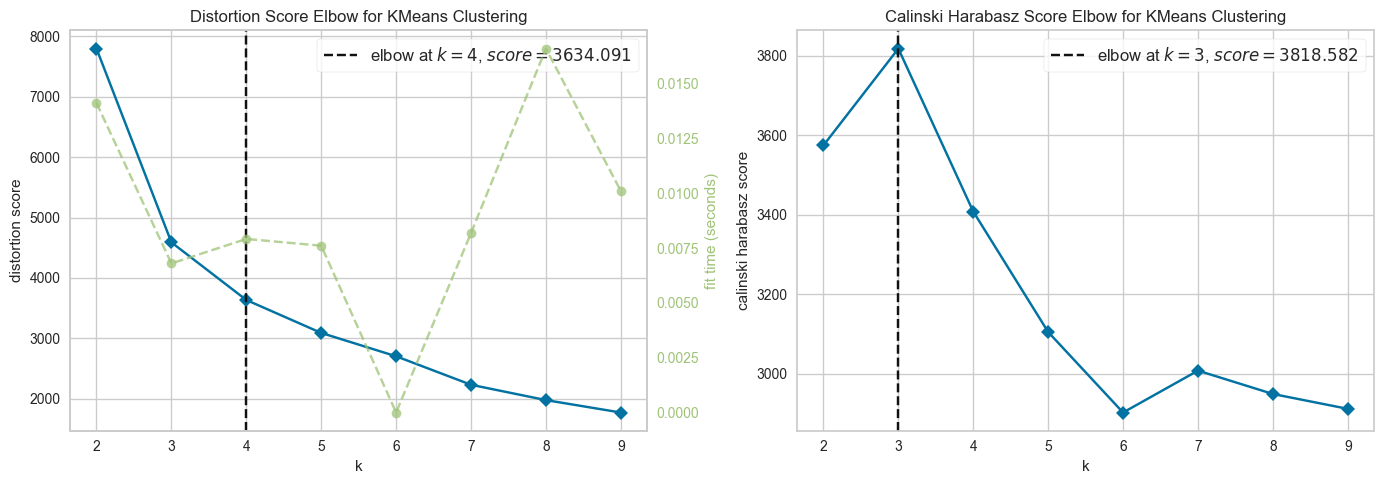

In [11]:
#k-means
# --- Define K-Means Functions ---
def kmeans():
    
    # --- Elbow Score ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Elbow method using distortion scoreelbow_score = KElbowVisualizer(KMeans(random_state=32, max_iter=500), k=(2, 10), ax=ax1)
    elbow_score = KElbowVisualizer(KMeans(random_state=32, max_iter=500), k=(2, 10), ax=ax1)
    elbow_score.fit(X)
    elbow_score.finalize()
    
    # Elbow method using Calinski-Harabasz Index
    elbow_score_ch = KElbowVisualizer(KMeans(random_state=32, max_iter=500), k=(2, 10), metric='calinski_harabasz', timings=False, ax=ax2)
    elbow_score_ch.fit(X)
    elbow_score_ch.finalize()
    
    # Show the plots
    plt.tight_layout()
    plt.show()

# --- Calling K-Means Functions ---
kmeans();


# K-Means可视化
-> 最终选择k = 4作为聚类数
对KMeans可视化分析：
1. 创建Silhouette，以评估聚类的紧密度和分离度

   结论：四个轮廓系数都不是很小，说明紧密度和分离度较好
2. 散点图展示了样本点在特征空间中的分布，其中黑点为聚类中心

   结论：四个簇之间的分离性良好
3. 饼图展示了四个聚类的比例大小

   结论：四个簇的相对比例没有过大或者过小

可视化分析只是初步评估，需要进一步对聚类质量评估
   

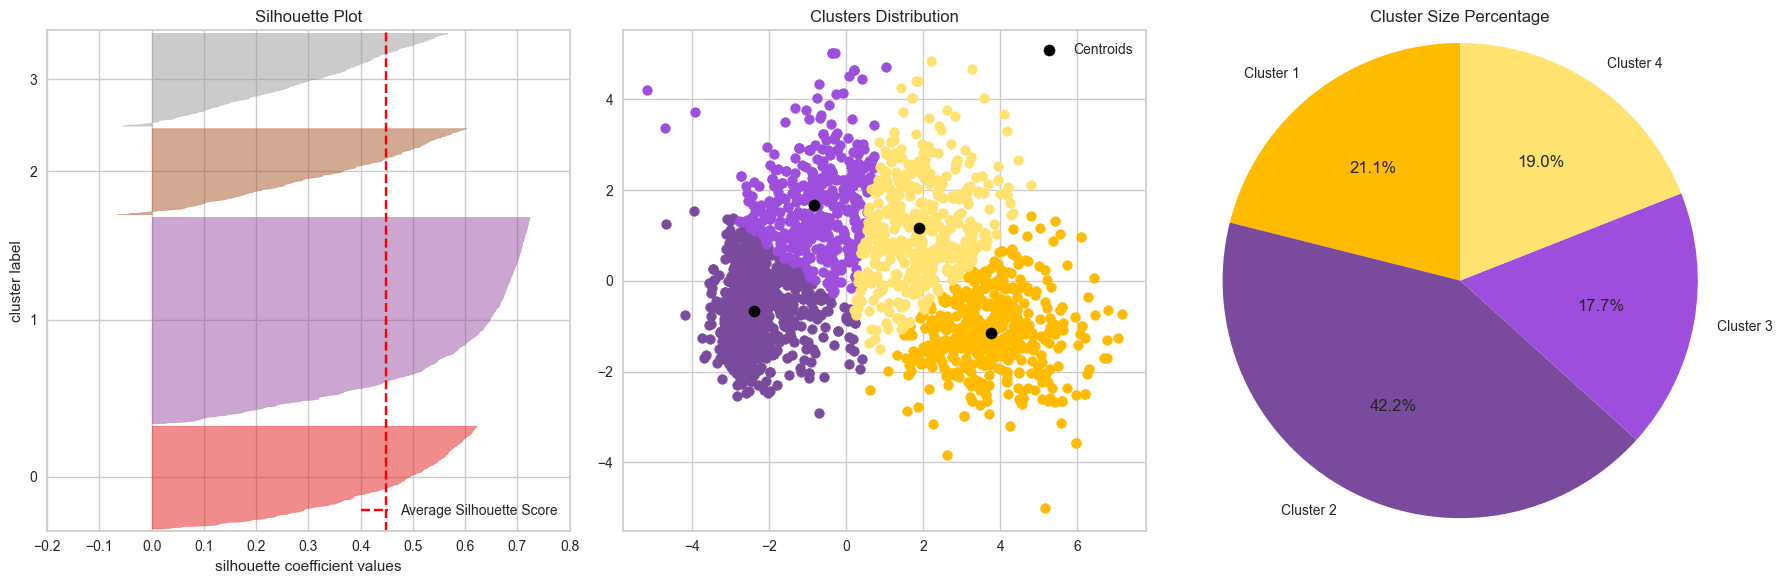

In [12]:
# --- Implementing K-Means ---
kmeans = KMeans(n_clusters=4, random_state=32, max_iter=500)
y_kmeans = kmeans.fit_predict(X)

# --- Define K-Means Visualizer & Plots ---
def visualizer(kmeans, y_kmeans):
    
    # --- Figures Settings ---
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # --- Silhouette Plot ---
    s_viz = SilhouetteVisualizer(kmeans, ax=ax1)
    s_viz.fit(X)
    s_viz.finalize()
    ax1.set_title('Silhouette Plot')
    
    # --- Clusters Distribution ---
    cluster_colors = ['#FFBB00', '#7A4B9D', '#9D4EDD', '#FFE270']
    y_kmeans_labels = list(set(y_kmeans.tolist()))
    for i in y_kmeans_labels:
        ax2.scatter(X[y_kmeans == i, 0], X[y_kmeans == i, 1], s=50, c=cluster_colors[i])
    ax2.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=65, c='black', label='Centroids')
    ax2.set_title('Clusters Distribution')
    ax2.legend()
    
    unique, counts = np.unique(y_kmeans, return_counts=True)
    sizes = counts / counts.sum() * 100  # percentage calculation
    ax3.pie(sizes, labels=[f'Cluster {i+1}' for i in unique], colors=cluster_colors, autopct='%1.1f%%', startangle=90)
    ax3.axis('equal')  #
    ax3.set_title('Cluster Size Percentage')
    
    plt.tight_layout()
    plt.show()
# --- Calling K-Means Visualizer ---
visualizer(kmeans, y_kmeans)



# K-Means评估
通过Davies-Bouldin Index、Silhouette Score和Calinski-Harabasz Index对K-Means进行聚类质量评估
1. Davies-Bouldin Index: 0.856， 越接近0越好
2. Silhouette Score: 0.449，越接近1越好
3. Calinski Harabasz Index: 3408.455，越大越好

K-Means效果中等偏上

In [13]:
# --- Evaluate Clustering Quality Function ---
def evaluate_clustering(X, y):
    db_index = round(davies_bouldin_score(X, y), 3)
    s_score = round(silhouette_score(X, y), 3)
    ch_index = round(calinski_harabasz_score(X, y), 3)
    print(clr.start+'.: Evaluate Clustering Quality :.'+clr.end)
    print(clr.color+'*' * 34+clr.end)
    print('.: Davies-Bouldin Index: '+clr.start, db_index)
    print(clr.end+'.: Silhouette Score: '+clr.start, s_score)
    print(clr.end+'.: Calinski Harabasz Index: '+clr.start, ch_index)
    return db_index, s_score, ch_index

# --- Evaluate K-Means Cluster Quality ---
db_kmeans, ss_kmeans, ch_kmeans = evaluate_clustering(X, y_kmeans)

.: Evaluate Clustering Quality :.
**********************************
.: Davies-Bouldin Index:  0.856
.: Silhouette Score:  0.449
.: Calinski Harabasz Index:  3408.455


# 找出最优eps值以进行DBSCAN聚类
最优eps值 = 2.1249524652071985

可能还需要寻找合适的min_sample

Optimal epsilon value at the change point: 2.1249524652071985


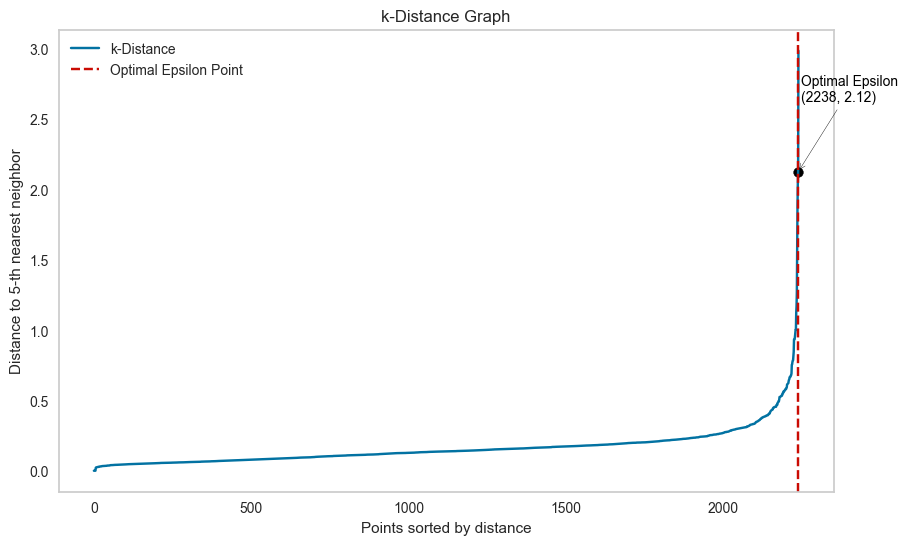

In [19]:
#DB-失败
min_samples = 5

# 计算 k-距离
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

# 获取第 k 个最近邻的距离（min_samples-1）
k_distance = np.sort(distances[:, min_samples-1], axis=0)

# 计算一阶导数
first_derivative = np.diff(k_distance)

# 计算二阶导数
second_derivative = np.diff(first_derivative)

# 寻找曲率最大的点
change_point = np.argmax(second_derivative) + 1  # +1 因为 np.diff 减少了一个元素

# 输出对应的 eps 值
optimal_eps = k_distance[change_point]
print(f'Optimal epsilon value at the change point: {optimal_eps}')

# 可视化
plt.figure(figsize=(10, 6))
plt.plot(k_distance, label='k-Distance')
plt.axvline(x=change_point, color='r', linestyle='--', label='Optimal Epsilon Point')
plt.title('k-Distance Graph')
plt.scatter(change_point, optimal_eps, color='black')  
plt.annotate(f'Optimal Epsilon\n({change_point}, {optimal_eps:.2f})',
             xy=(change_point, optimal_eps), 
             xytext=(change_point + 10, optimal_eps + 0.5),  # 文本位置
             arrowprops=dict(arrowstyle='->', color='black'),
             fontsize=10, color='black')# 标记最佳点
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {min_samples}-th nearest neighbor')
plt.legend()
plt.grid()
plt.show()

In [ ]:
clusters = shc.linkage(df, method="ward")

plt.figure(figsize=(8, 6))
dendrogram = shc.dendrogram(clusters)
# Plotting a horizontal line based on the first biggest distance between clusters 
plt.axhline(150, color='red', linestyle='--'); 
# Plotting a horizontal line based on the second biggest distance between clusters 
plt.axhline(100, color='crimson'); 